# Manually Coding Gradient Descent

In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class Regression:
    
    def __init__(self, learning_rate, regularization, n_epoch):
        self.learning_rate = learning_rate
        self.n_epoch = n_epoch
        self.regularization = regularization
        # initialize whichever variables you would need here
        self.coef = np.ones(4)
        self.coefs = []
        self.mse = []
        self.steps = 0
        
    def sgd(self, gradient):
        self.coef -= self.learning_rate*gradient
    
    def fit(self, X, y, update_rule='sgd', plot=False):
        mse = []
        coefs = []
        steps = 0
        X = self.get_features(X)
        for epoch in range(self.n_epoch):
            for i in range(X.shape[0]):
                # Compute error
                y_pred_i = self.linearPredict(X[i])
                yi = y[i]
                error = yi - y_pred_i

                # Compute gradients
                gradient = -1*error*X[i] + self.regularization*self.coef
                ##should use -1 instead of -2, as half MSE is used by convention in gradient, since gradient constants are effectively a learning rate
               
                # Update weights
                self.sgd(gradient)
                steps+=1

                self.coefs.append(self.coef.tolist())

            coefs.append(self.coef.tolist())
            residuals = y - self.linearPredict(X)
            mse.append(np.mean(residuals**2))
        self.mse = mse
        self.lowest_mse = mse[-1]
        self.steps = steps
        self.coefs = np.array(self.coefs)
        if plot == True:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
            ax1.set_title('MSE, Learning Rate: ' + str(self.learning_rate) + ', Regularization: ' + str(self.regularization))
            ax1.plot(range(self.n_epoch),mse)
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('MSE')
            ax2.set_title('Weights, Learning Rate: ' + str(self.learning_rate) + ', Regularization: ' + str(self.regularization))
            coefs = np.array(coefs)
            ax2.plot(range(self.n_epoch),coefs[:,0],label='w0')
            ax2.plot(range(self.n_epoch),coefs[:,1],label='w1')
            ax2.plot(range(self.n_epoch),coefs[:,2],label='w2')
            ax2.plot(range(self.n_epoch),coefs[:,3],label='w3')
            ax2.legend()
            ax2.set_xlabel('epoch')
            ax2.set_ylabel('parameter value')
            plt.show()

    def get_features(self, X):
        '''
        this output of this function can be used to compute the gradient in `fit`
        '''
        x = np.zeros((X.shape[0], 4))
        x[:,0] = 1
        x[:,1] = np.exp(-X[:,0])
        x[:,2] = X[:,0]
        x[:,3] = X[:,0]*X[:,1]
        
        return x
        
    def linearPredict(self, X):  
        return np.dot(X, self.coef) #compute the dot product of self.coef and X

In [2]:
data = pd.read_csv('SGD_samples.csv')
X = np.array([data['x1'].values, data['x2'].values]).T
y = data['y'].values

In [3]:
reg = Regression(0.01, 1, 5)
reg.fit(X,y)
print('MSE: ', reg.lowest_mse)
print('Steps: ', reg.steps)
print('Weights: ', reg.coef)

MSE:  0.03805903204595334
Steps:  2500
Weights:  [0.06617643 0.04149238 0.03354737 0.00837308]


# Tuning Hyperparameters

C:\Users\Rukh\AppData\Local\Temp\ipykernel_24156\965816146.py:35: RuntimeWarning: overflow encountered in multiply
  gradient = -1*error*X[i] + self.regularization*self.coef
C:\Users\Rukh\AppData\Local\Temp\ipykernel_24156\965816146.py:20: RuntimeWarning: invalid value encountered in subtract
  self.coef -= self.learning_rate*gradient
C:\Users\Rukh\AppData\Local\Temp\ipykernel_24156\965816146.py:46: RuntimeWarning: overflow encountered in square
  mse.append(np.mean(residuals**2))
C:\Users\Rukh\AppData\Local\Temp\ipykernel_24156\965816146.py:20: RuntimeWarning: overflow encountered in multiply
  self.coef -= self.learning_rate*gradient
C:\Users\Rukh\AppData\Local\Temp\ipykernel_24156\965816146.py:35: RuntimeWarning: invalid value encountered in multiply
  gradient = -1*error*X[i] + self.regularization*self.coef


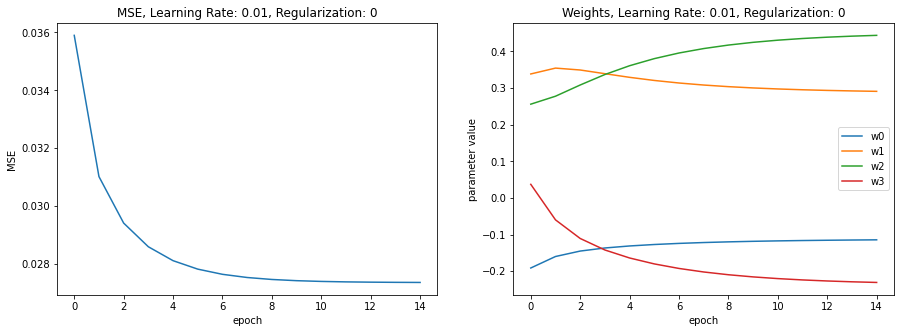

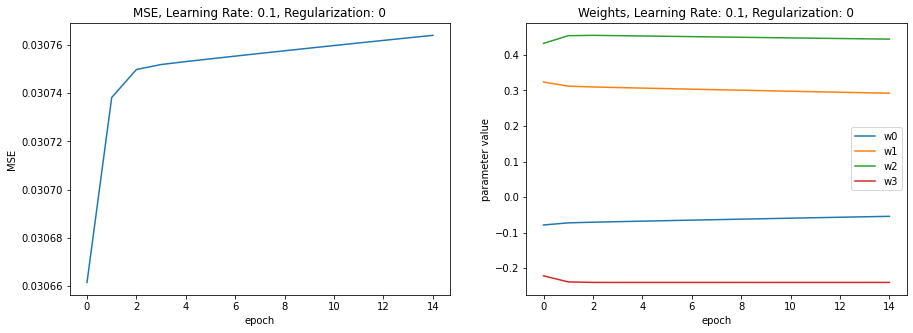

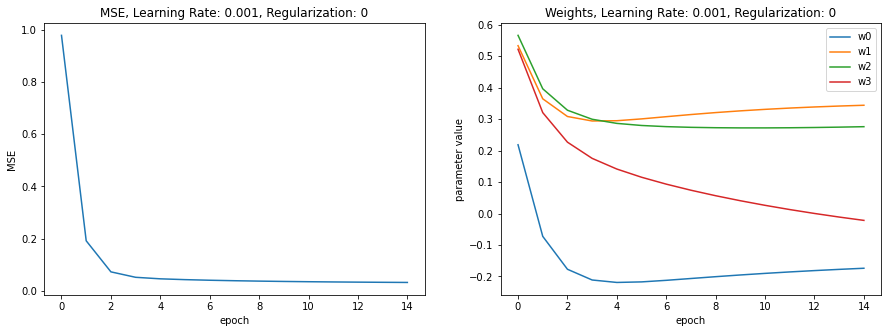

In [4]:
n_epochs = 15
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
regularization = [0, 1, 10, 100]

best_mse = []
best_learning_rate = []
best_regularization = []

for rate in learning_rate:
    for penalty in regularization:
        reg = Regression(rate, penalty, n_epochs)
        reg.fit(X,y)
        best_mse.append(reg.lowest_mse)
        best_learning_rate.append(rate)
        best_regularization.append(penalty)
        
for idx in np.argsort(best_mse)[:3]:
    reg = Regression(best_learning_rate[idx], best_regularization[idx], n_epochs)
    reg.fit(X,y,plot=True)

In [5]:
df = pd.DataFrame({'Learning Rate':best_learning_rate, 'Regularization':best_regularization, 'MSE':best_mse})
mse_df = df.groupby(['Learning Rate','Regularization']).mean().unstack()
mse_df

MSE                              
Regularization       0         1         10        100
Learning Rate                                         
0.0001          0.410047  0.096765  0.056036  0.063636
0.0010          0.032566  0.038160  0.056034  0.063492
0.0100          0.027359  0.038059  0.054626  0.063437
0.1000          0.030764  0.034957  0.055254       NaN
1.0000               inf       NaN       NaN       NaN
10.0000              NaN       NaN       NaN       NaN
100.0000             NaN       NaN       NaN       NaN

In [6]:
best_df = df.sort_values(by='MSE')[:5]
best_df = best_df.rename(columns={'MSE':'Loss with Penalty'})
best_df['Rank'] = ['Best', '2nd', '3rd', '4th', '5th']
best_df.set_index('Rank')

,Learning Rate,Regularization,Loss with Penalty
Rank,,,
Best,0.010,0,0.027359
2nd,0.100,0,0.030764
3rd,0.001,0,0.032566
4th,0.100,1,0.034957
5th,0.010,1,0.038059
